# Conflict Negotiation Model (CNM), an implementation and comparison with ad-hoc SFM and CBS-MAPF.

### The progression of this notebook is linear

The conducted tests will mainly use Mesa, a Python library developed to work with agent-based models.

# Conflict Negotiation Model

## Imports

In [1]:
import sys
print(sys.version)

3.13.2 (main, Feb  4 2025, 14:51:09) [Clang 16.0.0 (clang-1600.0.26.6)]


In [2]:
import mesa # version 3.0.0a4
# mesa, pathfinding, cbs-mapf
# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

import copy
# pathfinding library
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.core.diagonal_movement import DiagonalMovement

# Comparison
# CBS & STA* for MAPF, local library for ad-hoc
import sys
sys.path.append('./cbs_mapf')
from cbs_mapf.planner import Planner

# Visualization also has dependencies.

## Maps and utilities

In [3]:
map0 = [[0,1,0,0], # Dummy map, not used for tests
        [1,0,0,0],
        [0,0,0,41],
        [0,0,31,0]]

map1 = [[0,0,2,2,0],
        [1,0,0,0,1],
        [0,0,0,0,31],
        [2,2,2,2,0],
        [0,0,32,0,0]]

map2 = [[0,0,0,2,0,0,1],
        [0,0,0,0,2,2,0],
        [0,0,2,0,0,0,0],
        [0,32,0,0,0,0,31],
        [0,0,2,0,2,2,0],
        [0,0,2,0,2,0,0],
        [33,0,2,2,0,0,1]    
       ]

map3 =  [[0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 0, 0, 0, 1],
         [0, 0, 0, 0, 2, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 2, 0, 0, 0, 0, 0],
         [32, 0, 0, 0, 31, 0, 0, 0, 0, 0],
         [0, 0, 0, 2, 0, 2, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 2, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 2, 2, 0, 0, 0],
         [0, 0, 0, 0, 2, 2, 0, 0, 0, 0],
        ]

map4 = [
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0],
 [0, 0, 0, 0, 34, 0, 2, 32, 0, 0, 31, 0, 1, 0, 1],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0],
 [0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 1],
 [0, 35, 0, 0, 2, 0, 33, 0, 2, 0, 2, 0, 0, 1, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
]

map5 = [
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0],
 [0, 0, 0, 0, 32, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 1, 0],
 [0, 0, 0, 0, 2, 0, 0, 31, 2, 0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0],
 [0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 0, 0, 0, 0],
 [33, 0, 0, 0, 2, 1, 2, 1, 2, 0, 2, 0, 0, 0, 0],
]

map6 = [
    [0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
    [0, 1, 0, 2, 0, 0, 2, 0, 1, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
    [42, 1, 0, 31, 0, 0, 41, 0, 1, 32],
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 2, 0, 0, 2, 0, 1, 0],
    [0, 1, 0, 2, 0, 0, 2, 0, 1, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 2, 0, 0, 2, 0, 0, 0]
]

map7 = [ [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2],
  [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
  [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0],
  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
  [31, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 41],
  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
  [0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0],
  [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2]
]

map8 = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0], # Test map, not used for tests
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [31, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 41],
    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

maps = [map0, map1, map2, map3, map4, map5, map6, map7, map8]

def transform_grid(card):
    """
        Short utility function to only consider free (1) and obstacles (0) in the map.
        Used to collaborate with the pathfinding library.
    """
    new_map = []
    for row in card:
        new_col = []
        for col in row:
            if col == 2: # Obstacle
                new_col.append(0)
            else:
                new_col.append(1)
        new_map.append(new_col)
    return new_map

print(transform_grid(map1))

def convert_coords(pos):
    """
        Convert real coordinates to integer coordinates.
    """
    return (round(pos[0]), round(pos[1]))

def is_walkable(grid, position, unique_id):
    pos = position
    for a in grid.get_neighbors(pos, .1, True):
        if a.unique_id != unique_id and not isinstance(a, Objective):
            return False
    return True

def collides(path1, path2):
    if len(path2) < len(path1):
        path1, path2 = path2, path1
    # Bias of collision: the crossing is considered more important as an imminent collision
    #if len(path1) > 1:
    # Bias of selection: the shortest path is considered with the colliding point, i.e., the agent with the longest path is the obstacle   
    # We may include the other colliding point later.
    # Common path
    for i in range(len(path1)-1):
        p1 = path1[i]
        p1_n = path1[i+1]
        p2 = path2[i]
        # Crossing paths
        if p1_n[0] == p2[0] and p1_n[1] == p2[1]:
            return (p2[0], p2[1])
        # Virtual obstacle
        if p1[0] == p2[0] and p1[1] == p2[1]:
            return (p1[0], p1[1])
    # Check last cell which cannot be crossing path as it has already been checked
    if path1[len(path1)-1][0] == path2[len(path1)-1][0] and path1[len(path1)-1][1] == path2[len(path1)-1][1]:
        return (path1[len(path1)-1][0], path1[len(path1)-1][1])
    return None

[[1, 1, 0, 0, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 0, 0, 0, 1], [1, 1, 1, 1, 1]]


## Some tests before diving into CNM

### Short test of pathfinding with A*

In [4]:
mapp = transform_grid(map1[::-1])
for r in mapp:
    print(r)
grid = Grid(height=5, width=5, matrix = mapp, inverse=False, grid_id=1)

grid_self_pos = (0, 1)

start = grid.node(grid_self_pos[0], grid_self_pos[1])
end = grid.node(2,4)

finder = AStarFinder(diagonal_movement = DiagonalMovement.always)
path, runs = finder.find_path(start, end, grid)

print("Found path:")
for p in path:
    print((p.x, p.y), end='; ')
print()

[1, 1, 1, 1, 1]
[0, 0, 0, 0, 1]
[1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[1, 1, 0, 0, 1]
Found path:



### Preferences and tests

In [5]:
# Give two virtual agents their features.
motivations = [.5, .5]
objectives = [(5,5), (-2, -3)]
positions = [(0, 0), (3,4)]
trajectories = [6, 4] # paths sizes
speed = [2.4, 1.8] # m/s

# Equivalent cost function used for test.
def cost(agent):
    mot = motivations[agent]
    pos = np.array(positions[agent])
    objective = np.array(objectives[agent])
    dist = np.linalg.norm(pos-objective)
    size = trajectories[agent]
    print(f"dist of agent {agent}: {dist}")
    return round((4 * size) / dist + speed[agent] + (1 / mot), 3)

# Current proposed function in the article, K1, K2 and K3 but also the function may differ from the article
# as some work was ongoing. However, results displayed in the article were obtained using the article's version of the cost function. 
def path_cost(agent, path):
    mot = agent.motivation
    pos = agent.position
    goal = agent.objective
    speed = agent.speed
    dist = agent.model.grid.get_distance(pos, goal)
    size = len(path)
    if dist <= 0:
        return -1
    cost = round((2 * size) / dist + speed + (1 / mot), 3)
    #if size > 1:
    #    for i in range(size-1):
    #        if path[i] == path[i+1]:
    #            # Wait process
    #            cost += 5
    return cost

def estimate_trajectory(direction):
    """
        This current trajectory estimation is done through linear approximation.
    """
    dx, dy = direction
    pass

for agent in range(2):
    print(f"cost of agent {agent}: {cost(agent)}")

dist of agent 0: 7.0710678118654755
cost of agent 0: 7.794
dist of agent 1: 8.602325267042627
cost of agent 1: 5.66


### Some tests on CBS-MAPF

In [6]:
def get_static_obstacles(mapp):
    static_obstacles = []
    obstacle_id = 2
    for y in range(len(mapp)):
        for x in range(len(mapp[y])):
            if mapp[y][x] == obstacle_id:
                static_obstacles.append((x, y))
    return static_obstacles

def get_agent_starts(mapp):
    agts = []
    agt_id = 1
    for y in range(len(mapp)):
        for x in range(len(mapp[y])):
            if mapp[y][x] == agt_id:
                agts.append((x, y))
    return agts

def find_goal(mapp):
    goal_id = 3
    for y in range(len(mapp)):
        for x in range(len(mapp[y])):
            if mapp[y][x] == goal_id:
                return (x, y)

map_ = [[0,0,0,2,0,0,1], # map2
        [0,0,2,2,2,2,0],
        [0,0,2,0,0,0,0],
        [0,0,0,0,0,0,0],
        [0,0,2,0,2,2,0],
        [0,0,2,0,2,0,0],
        [3,0,2,2,0,0,1]    
       ]

# Call cbs-mapf to plan
start = get_agent_starts(map_)
print("starts", start)
obj = find_goal(map_)
goal = [obj for _ in range(len(start))]
print("goals", goal)
#assert(len(start) == len(goal))
planner = Planner(map_)
path = planner.plan(start, goal, debug=False)
print("type", path.shape)
print(path)

starts [(6, 0), (6, 6)]
goals [(0, 6), (0, 6)]
type (2, 10, 2)
[[[6 0]
  [6 1]
  [5 2]
  [4 2]
  [3 3]
  [2 3]
  [1 4]
  [1 5]
  [0 6]
  [0 6]]

 [[6 6]
  [6 5]
  [6 4]
  [5 3]
  [4 3]
  [3 3]
  [2 3]
  [1 4]
  [1 5]
  [0 6]]]


## Experiments - Evaluation function

In [7]:
# Evaluation
# This function evaluates the metrics defined in the article for a given set of agents, post simulation.
def get_evaluation(agents):
    # Metrics
    dist = 0
    wait = 0
    equi_vals = []
    equi = 0
    # Ti+, Ti*, Tau_i
    results = [0, 0, 0]
    for agent in agents:
        dirty_tip = agent.global_path
        #print("dirty tip", dirty_tip)
        # Clear paths, i.e., remove waitings for Ti+
        tip = [dirty_tip[0]] + [b for a, b in zip(dirty_tip, dirty_tip[1:]) if a != b]
        # But also for SFM, remove going extra-borders agents with respect to goal
        # First, check if there is one goal reaching cell
        stip = len(tip)
        if isinstance(agent, SFPed):
            objective = agent.final_objective
            # Check if the path is reached, with some tolerance threshold for SFM only
            last_reached_index = next((i for i, cell in enumerate(tip) if np.linalg.norm(np.array(cell) - np.array(objective)) < 2), None)
            if last_reached_index is not None:
                tip = tip[:last_reached_index + 1]
                stip = len(tip)
                #print("shortened path", tip)
                #print("len", stip)
            else:
                # Filter out any cell that exceeds the 1.2 times the distance between the start and goal
                tip = list(filter(lambda cell: np.linalg.norm(np.array(cell) - np.array(objective)) < 1.2 * np.linalg.norm(np.array(tip[0]) - np.array(objective)), dirty_tip))
                stip = -1 # still the goal was not reached
        tis = agent.optimal_path
        tau = agent.tau
        # Distance metric
        stis = len(tis)
        #print("lenstis", stis)
        dist += (stis / stip) if stip > 0 else 0 # Infinity size(T_i^+)
        # Wait metric
        wait += tau - len(tip)
        # Equity metric
        equi_vals.append(wait)
    # Compute metrics
    n = len(agents)
    results[0] = dist / n
    results[1] = wait / n
    results[2] = np.std(equi_vals, ddof=1) # unbiased for sample population
    return tuple(results)

## Agent model

In [8]:
class Ped(mesa.Agent):
    # Defines the CNM agent (pedestrian).
    def __init__(self, model, pos):
        super().__init__(model)

        # Evaluation
        self.global_path = [] # Tip
        self.optimal_path = [] # Tis
        self.tau = 0 # Taui

        # If the agent still didn't reach its objective
        self.active = True

        # Traits
        self.motivation = min(.3, np.random.rand()) # 0.3-1
        self.speed = np.random.rand() + 1
        #self.satisfaction = np.random.uniform(-3, 1) # Satisfaction threshold of the current situation the agent is in.
        # The lower the satisfaction the more an agent can acclimate to the others. This choice shall be discussed more deeply, it seems motivation is the better fit right now.
        self.attention = min(.3, np.random.rand())

        self.position = pos
        self.direction = None
        self.alert = False
        self.wait = False
        self.path = None
        self.negotiating = False
        self.current_cost = -1
        self.alternatives = {}
        self.influenced = False
    
    def set_objective(self, obj):
        self.objective_obj = obj
        self.objective = obj.position
        
        # Evaluation, should be made only once
        self.optimal_path = list(self.find_path())

    def find_path(self, obstacles=None, diag=True):
        #TODO add current positions as obstacles
        grid = None
        if obstacles is None:
            grid = Grid(height=len(self.model.card), width=len(self.model.card[0]), matrix = self.model.card, inverse=False, grid_id=1)
        else:
            matrix = copy.deepcopy(self.model.card)
            for obstacle in obstacles:
                x, y = obstacle
                matrix[y][x] = 0
            grid = Grid(height=len(self.model.card), width=len(self.model.card[0]), matrix = matrix, inverse=False, grid_id=2)
        
        grid_self_pos = convert_coords(self.position)

        start = grid.node(grid_self_pos[0], grid_self_pos[1])
        end = grid.node(self.objective[0], self.objective[1])

        finder = AStarFinder(diagonal_movement = DiagonalMovement.always if diag else DiagonalMovement.never)
        path, runs = finder.find_path(start, end, grid)

        cell = lambda c : (c.x, c.y)
        path = list(map(cell, path))
        return None if len(path) == 0 else tuple(path) # Convert the paths to a tuple of pairs as it is hashable.

    def get_direction(self):
        if self.path is not None and len(self.path) > 1:
            end = np.array((self.path[1][0], self.path[1][1]))
            start = np.array((self.position[0], self.position[1]))
            data = end - start

            if not (data == 0).all():
                data = data / np.linalg.norm(data)
            
            def round_to_half_unit(n):
                return round(n * 2) / 2
            
            self.direction = list(map(round, data))
            # self.model.log(f"{self.unique_id} changed direction.")
            # self.model.log(f"{self.unique_id}'s current path: {self.path}")
    
    """
        Self utility function to consider a proposed path with its associated cost.
        If the current agent finds the proposition considerable, relative to its satisfaction and the proposed cost,
        then it reconsiders the best suitable alternative (collision-free) by re-evaluating its associated cost (diminish it).
    """
    def consider_alternative(self, path, cost):
        # Sort alternatives in ascending cost order, for now the agents want to avoid collision
        if len(self.alternatives) <= 0:
            self.compute_set()
            if len(self.alternatives) <= 0: # Blocked agent
                return False
            
        alts = sorted(self.alternatives, key=self.alternatives.get)
        # Get the first collision-free alternative
        best_alt = None
        for alt in alts:
            if collides(alt, path) is None: # Found one
                best_alt = alt
                break
        # If a CF-trajectory was not found, find a potential alternative
        best_alt_2 = None
        if best_alt is None:
            # We didn't find an alternative, compute one
            self.colliding_point = collides(alts[0], path)
            colliding_points = [self.colliding_point]
            for neigh in self.model.grid.get_neighbors(self.position, 2, False):
                if isinstance(neigh, Ped) and neigh.active:
                    colliding_points.append(neigh.position)
            best_alt = self.find_path(obstacles = colliding_points) # Compute a new CF trajectory (part of the recompute actually)
            best_alt_2 = self.find_path(obstacles = colliding_points, diag=False)

            if best_alt is None and best_alt_2 is None: # If not found, get the best possible alternative w.r.t. the given cost
                self.model.log(f"{self.unique_id} didn't find a collision-free path, best alternative.")
                best_alts = list(filter(lambda p: self.alternatives[p] - self.motivation <= cost, alts))
                if len(best_alts) > 0:
                    best_alt = min(best_alts)
            
            # Save alternative if valid
            no_alt = True
            if best_alt is not None:
                self.add_alternative(best_alt)
                no_alt = False
            if best_alt_2 is not None:
                self.add_alternative(best_alt_2)
                no_alt = False
            if no_alt:
                self.model.log(f"{self.unique_id} had no alternative.")
                return False
        
        if best_alt == self.path or best_alt_2 == self.path: # If the considered path is the same we considered, ignore.
            self.model.log(f"{self.unique_id} was already planning on to take this alternative.")
            return True
        
        # Diag or not
        if best_alt_2 is not None:
            best_alt = min([best_alt, best_alt_2], key=self.alternatives.get)

        # NB: we first consider CF trajectory as a priority to avoid collision, however we may consider
        # another threshold (e.g. 2*motivation) that fixes the tolerance of one to avoid non-imminent collision        

        # Compute the value of worthiness to take this alternative compared to the envisioned cost of the other's
        value = cost - self.alternatives[best_alt]
        self.model.log(f"An influence happened: {self.unique_id} processes a change of value {value}.")
        if value > self.motivation: # If the agent is satisfied with this alternative, it takes it. The cost should change.
            self.model.log(f"> {self.unique_id} reconsiders an alternative.")
            #self.alternatives[best_alt] = self.alternatives[min(self.alternatives, key=self.alternatives.get)] # We consider a cost similar to its best alternative as a measure of consideration.
            self.alternatives[best_alt] = max(0, self.alternatives[best_alt] - min(abs(value), 3)) # The motivation may represent a cost adaptation to the others' offers, the less we win negotiations, the less we want to adapt ourselves
            self.model.log(f"{self.unique_id}'s alternatives: {self.alternatives}")
            new_path = self.select_path()
            if new_path is not None and new_path != self.path:
                self.model.log(f"> {self.unique_id} takes another alternative.")
                self.path = new_path
            self.influenced = True
            return True
        
        self.model.log(f"> {self.unique_id} agent refused the alternative.")
        # Otherwise the agent did not consider it
        return False
    
    def select_path(self):
        """
            Cognition part
        """
        if len(self.alternatives) > 0:
            bests = sorted(self.alternatives, key=self.alternatives.get)
            best = bests[0]
            #collision_free = list(filter(lambda p: is_walkable(self.model.grid, p[1], self.unique_id), bests))
            #if len(collision_free) > 0:
            #    best = min(collision_free)
            #self.model.log(f"{self.unique_id} has {len(self.alternatives)} alternatives: selected one with cost {self.alternatives[best]}")
            #self.model.log(f"Alternatives of {self.unique_id}: {self.alternatives}")
            return best
        return None
    
    def compute_set(self, obstacles=None):
        """
            To enrich
        """
        # TBR
        path = self.find_path(obstacles=obstacles)
        path_wait = (convert_coords(self.position),) + self.find_path(obstacles=obstacles)
        #self.model.log(f"{self.unique_id}'s path cost: {path_cost(self, path)}")
        #self.model.log(f"{self.unique_id}'s path_wait cost: {path_cost(self, path_wait)}")
        if path is not None:
            self.add_alternative(path)
        if self.model.params["include_wait"]:
            if path_wait is not None:
                self.add_alternative(path_wait)

    def clear_set(self):
        self.alternatives = {}
    
    def negotiate(self, neigh):
        self.negotiating = True
        self.colliding_point = collides(self.path, neigh.path)
        if self.colliding_point is not None:
            self.alert = True
            self.bargainer = neigh
            match self.model.params["negotiation"]:
                case "wait_only":
                    if path_cost(self, self.path) < path_cost(self.bargainer, self.bargainer.path):
                        self.wait = True
                    self.bargainer.current_cost = path_cost(self.bargainer, self.bargainer.path)
                    self.current_cost = path_cost(self, self.path)
                case "alt_or_wait":
                    alt_path = self.find_path(obstacles = [self.colliding_point], diag = True)
                    alt_pathneigh = self.bargainer.find_path(obstacles = [self.colliding_point], diag = True)
                    if alt_path is None or alt_pathneigh is None:
                        if path_cost(self, self.path) > path_cost(self.bargainer, self.bargainer.path):
                            self.wait = True
                        else:
                            self.bargainer.wait = True
                    elif path_cost(self, alt_path) > path_cost(self.bargainer, alt_pathneigh):
                        self.bargainer.path = alt_pathneigh
                        self.bargainer.get_direction()
                    else:
                        self.path = alt_path
                        self.get_direction() # update direction!!
                    #TODO à mettre à jour
                    self.current_cost = path_cost(self, alt_path)
                    self.bargainer.current_cost = path_cost(self.bargainer, alt_pathneigh)

    def add_alternative(self, path):
        #self.model.log(f"{self.unique_id}'s added path with cost: {path_cost(self, path)}")
        self.alternatives[path] = path_cost(self, path)

    def init(self):
        # First cognition step, to show trajectories.
        self.compute_set()
        self.path = self.select_path()
        self.get_direction()
    
    def get_next_position(self):
        """
            @returns: The next position given by the direction.
        """
        return (self.position[0] + self.direction[0], self.position[1] + self.direction[1])
    
    def move(self, position):
        """
            Attempt to move self to the given position.
            
            @returns: True if it moved, False otherwise
        """
        if is_walkable(self.model.grid, position, self.unique_id):
            self.position = position
            self.model.grid.move_agent(self, self.position)
            self.path = self.path[1:]

            # Evaluation
            self.global_path.append(list(self.position))
            return True
        return False

    def step(self):
        if not self.active:
            return
        
        # Evaluation
        self.tau += 1
        
        # Reset (in order)
        self.negotiating = False
        self.alert = False
        self.colliding_point = None
        self.influenced = False

        # Cognition is supposed to be before motion, in order, however the initialisation step takes care of it.
        
        ### Move agent
        
        #self.position = (self.position[0] + .2, self.position[1] + .2)
        alt = False
        if not self.wait:
            moved = False
            position = self.get_next_position()
            if self.direction is not None:
                ## Check collision
                moved = self.move(position)
            # Otherwise wait or re-engage: to be discussed
            # if an agent cannot move forward it is probably because there is some congestion, a negotiation process is quite meaningless here. Consider own alternative trajectory.
            #
            # This step is very important to discuss. In fact, the motion happens before the cognition part because of the initialization.
            # As such, if the agent considers another alternative then it triggers the cognition part in advance and then moves. In order to respect the execution order the agent has to recompute its direction
            # one more time to ensure the next move.
            if not moved and not self.influenced:
                self.model.log(f"{self.unique_id} is blocked and not under influence, it considers another alternative.")
                mode = "do_nothing" # reflex?
                match mode:
                    case "instant_alternative":
                        colliding_points = [position]
                        for neigh in self.model.grid.get_neighbors(self.position, 2, False):
                            if isinstance(neigh, Ped) and neigh.active:
                                colliding_points.append(neigh.position)
                        
                        self.compute_set(obstacles=colliding_points)
                        path = self.select_path()
                        if path is not None:
                            self.path = path
                            self.get_direction()
                            position = self.get_next_position()
                            self.move(position)
                            self.get_direction()
                            alt = True
                    #case _:
                        # Wait by default
        elif self.model.params["include_wait"]:
            # Waiting may be in the trajectory
            self.path = self.path[1:]
                        
        
        if self.position == self.objective:
            self.active = False
            self.model.grid.remove_agent(self)
            return
        
        ### Cognition
        match self.model.params["model"]:
            case "first":
                self.compute_set()
                self.path = self.select_path()
                self.get_direction()
            case "second":
                self.clear_set() # is it fixed to compute_set? maybe
                self.compute_set()
                if not alt and not self.influenced:
                    self.path = self.select_path()
                    self.get_direction()

        # Reset
        self.wait = False

### Other agents, useful for storage

In [9]:
class Obstacle(mesa.Agent):
    
    def __init__(self, model, pos):
        super().__init__(model)
        self.position = pos

    def step(self):
        pass

class Objective(mesa.Agent):
    
    def __init__(self, model, pos, id, number=-1, step=-1):
        super().__init__(model)
        self.position = pos
        self.id = id
        self.step = step
        self.number = number

    def step(self):
        pass

## CNM - Global model

### Negotiation process

In [10]:
class Negotiation():
    """
        A negotiation process happens between at least two agents, for now, in case of a collision.
        A negotiation is the influence of a1 towards a2, a1 is trying to change the a2's preferences, with possible failure.

        The following negotiation will happen:
            a1 --->(influences) a2
    """
    def __init__(self, model, a1, a2):
        self.a1 = a1
        self.a2 = a2
        self.model = model

    """
        The negotiation process starts here, the result of such a process results in a failure for a1 or not.

        @returns: False if a1 didn't suceed in its bargaining, True otherwise.
    """
    def start(self):
        result = False # No success for negotiation at beginning.

        # Option
        mode = "self_trajectory" # to change to self.model.params["influence_mode"]

        match mode:
            case "self_trajectory":
                """
                    This mode describes a1's influence as the proposal of its trajectory as an influence towards a2.
                    a1's trajectory (i.e., path) is communicated along its cost to reveal (do we consider dishonesty?) its willingness/unwillingness to change path.
                    a2 can then choose to either re-evaluate its best alternative collision-free trajectory's (w.r.t to a1's proposed path) cost, if it considers it worth it
                    according to its tolerance threshold/motivation.
                """
                a1 = self.a1
                a2 = self.a2
                # a1 proposes its trajectory to a2
                ## a2 evaluates it and computes an alternative w.r.t. its threshold
                self.model.log(f"{a1.unique_id} negotiates with {a2.unique_id}")
                considered = a2.consider_alternative(a1.path, path_cost(a1, a1.path)) # TBI
                if considered:
                    a2.get_direction()
                return considered
            case _:
                self.model.log("[Error] Unknown influence method. Abort influence.")
                return False

        return result

### Vote and negotiations process

In [11]:
class Vote():
    def __init__(self, model, agents):
        self.model = model
        self.neg_schedule = mesa.time.BaseScheduler(model, agents)
        #for a in agents: for randomactivation
        #    self.neg_schedule.add(a)
        self.step = 0
        self.DELTA = 3 # Option
        self.conflicts = []
    
    def start(self):
        self.model.log("------- Vote started -------")
        while self.step < self.DELTA:
            self.model.log(f"--- Iteration {self.step} ---")
            if not self.iter():
                self.model.log("The vote ended prematurely, as there was no collision.")
                self.model.log("------- Vote ended -------")# Clear alternatives
                for a in self.neg_schedule.agents:
                    a.clear_set()
                return
        # Check collisions
        for conflict in self.conflicts:
            # If there remain *IMMINENT* collisions then wait for some agents
            a, neigh = conflict
            # sort speed?? done here
            # in truth, the colliding point may be updated even if paths were not updated, so it should be saved before
            colliding_point = collides(a.path, neigh.path)
            if len(a.path) > 1 and is_walkable(self.model.grid, a.path[1], a.unique_id) and a.path[1] != colliding_point:
                continue
            if len(neigh.path) > 1 and is_walkable(self.model.grid, neigh.path[1], neigh.unique_id) and neigh.path[1] != colliding_point:
                continue
            # Otherwise, imminent collision, wait for the one that has the most motivation
            if a.motivation > neigh.motivation:
                self.model.log(f"> {a.unique_id} waited as negotiations didn't conclude.")
                a.wait = True
            else:
                self.model.log(f"> {neigh.unique_id} waited as negotiations didn't conclude.")
                neigh.wait = True
        # Clear alternatives and end negotiations
        for a in self.neg_schedule.agents:
            a.clear_set()
        self.model.log("------- Vote ended -------")
    
    def compute_welfare(self, collisions):
        # Option
        # param: mean
        welfare = 0
        for c in collisions:
            a, neigh = c
            welfare += abs(path_cost(a, a.path) - path_cost(neigh, neigh.path))
        welfare /= len(collisions)
        return welfare

    def iter(self):

        # I. Vote
        # For now, each agent proposes its trajectory as its vote. If there is a collision, then negotiations continue.
        ## To check on litterature
        self.conflicts = [] # Pairs of agents that have conflicts between their respective paths
        no_conflicts = []
        DELTA = 2
        for a in self.neg_schedule.agents:
           for neigh in self.model.grid.get_neighbors(a.position, DELTA, False):
                if isinstance(neigh, Ped) and neigh.active and not neigh.alert:
                    if neigh.unique_id != a.unique_id:
                        if collides(a.path, neigh.path) and (a, neigh) not in self.conflicts and (neigh, a) not in self.conflicts:
                            self.model.log(f"Conflict between {a.unique_id} and {neigh.unique_id}")
                            self.conflicts.append((a, neigh))
                        else:
                            no_conflicts.append((a, neigh))

        ## If there is no conflict between agents, then negotiation ends.
        # Option: This should be parameterized as agents may want to negotiate better trajectories even though there is no collision.
        if self.conflicts == []:
            self.model.log("No conflict")
            return False # End vote
        
        ## Compute welfare, all agents can get to know the welfare.
        self.model.welfare = self.compute_welfare(self.conflicts)

        # II. Influences
        gain = .2 # Option
        ## The agents influence themselves, e.g., try to impose their trajectory to others in order to change costs or votes.
        for conflict in self.conflicts:
            a, neigh = conflict
            # Option: even if the agent is satisfied with the global welfare, if there remains a collision he can influence the other to take an advantaging trajectory for it.
            # Satisfaction alone seems too independent and not relevant alone. We should consider satisfaction computed through the preferences to consider the relevancy of negotiations or not.
            # The motivation is also considered through the cost function. Is it really different?
            # In any case agents, here, should negotiate if there is a collision regardless of their satisfaction (reality constraint).
            #if a.satisfaction < self.model.welfare:
            # The satisfaction parameter should then play in collision-free trajectory agents.
            a.negotiating = True
            neigh.negotiating = True

            # Roll dices for attention
            if self.model.params["attention"]:
                if np.random.rand() >= neigh.attention:
                    # a negotiates with neigh
                    success1 = Negotiation(self.model, a, neigh).start()
                    if not success1 and a.motivation - gain <= 0:
                        a.motivation /= 2
                    else:
                        a.motivation += gain if success1 else -gain
                else:
                    a.motivation /= 2
                #a.motivation = max(.000001, a.motivation)
            else:
                success1 = Negotiation(self.model, a, neigh).start()
                if not success1 and a.motivation - gain <= 0:
                    a.motivation /= 2
                else:
                    a.motivation += gain if success1 else -gain

            if self.model.params["attention"]:
                if np.random.rand() >= a.attention:
                    # neigh negotiates with a
                    success2 = Negotiation(self.model, neigh, a).start()
                    if not success2 and neigh.motivation - gain <= 0:
                        neigh.motivation /= 2
                    else:
                        neigh.motivation += gain if success2 else -gain
                else:
                    neigh.motivation /= 2
                #neigh.motivation = max(.000001, neigh.motivation)
            else:
                success2 = Negotiation(self.model, neigh, a).start()
                if not success2 and neigh.motivation - gain <= 0:
                    neigh.motivation /= 2
                else:
                    neigh.motivation += gain if success2 else -gain
        
        # TO ADD
        for no_conflict in no_conflicts:
            continue
        
        self.step += 1
        return True

### Model dynamics

In [12]:
class CNM(mesa.Model):
    # This class orchestrates the simulation's dynamics
    def __invert_y_coord(self, grid):
        return grid[::-1]

    def __init__(self, params, seed=None):
        """
            Create a continuous space model with discretized time with the given map (2D array).
        """
        super().__init__()

        # Model param
        self.MAX_STEP = 50
        self.step_value = 0

        # Retrieve params
        self.params = params
        card = copy.deepcopy(params["map"])

        # Set seed
        if seed is not None:
            np.random.seed(seed)
            
        # Params
        self.EXTRA_BORDER = 0
        self.card = self.__invert_y_coord(card)
        self.grid = mesa.space.ContinuousSpace(x_max = len(self.card[0]) + self.EXTRA_BORDER, y_max = len(self.card) + self.EXTRA_BORDER, torus = True, x_min=-self.EXTRA_BORDER, y_min=-self.EXTRA_BORDER)
        self.schedule = mesa.time.RandomActivation(self)
        self.obstacles = []
        self.welfare = 0 # Initial welfare
        self.objectives = []

        # Debug
        self.msgs = []
        
        self.num_agents = 0
        objective_id = 0
        # Create agents
        for y in range(len(self.card)):
            for x in range(len(self.card[y])):
                obj = self.card[y][x]
                if obj == 1: # Agent
                    a = Ped(self, (x, y))
                    a.unique_id = self.num_agents
                    self.num_agents += 1
                    self.schedule.add(a)
                    self.grid.place_agent(a, a.position)
                elif obj == 2: # Obstacle
                    o = Obstacle(self, (x, y))
                    self.grid.place_agent(o, o.position)
                    self.obstacles.append(o.position)
                elif obj >= 3: # Multiple objectives possible (apart from sub-objectives)
                    meta_info = list(map(int, list(str(obj)))) # Objective 31 refers as Objective 1 (number 3) and first step (1)
                    #print("--- meta info:", meta_info)
                    obj_number, obj_step = meta_info[0], meta_info[1]
                    o = Objective(self, (x, y), objective_id, number=obj_number, step=obj_step)
                    objective_id += 1
                    self.objectives.append(o)
                    self.grid.place_agent(o, o.position)
                # Otherwise empty
        
        # Update map for pathfinding
        self.card = transform_grid(self.card)
        
        # Add objective for all agents
        # For simplification purposes, let us assume agents take the farthest objective.
        for agent in self.schedule.agents:
            if isinstance(agent, Ped):
                dist = lambda o: np.linalg.norm(np.array(agent.position) - np.array(o.position))
                agent.set_objective(max(self.objectives, key=dist))
        
        # Init agents
        for agent in self.schedule.agents:
            if isinstance(agent, Ped):
                agent.init()
        
        # First vote for instant-collision management
        RADIUS = 2 # radius, attention at 100% here
        for a in self.schedule.agents:
            if not a.active or a.negotiating:
                continue
            neighbors = list(filter(lambda neigh: isinstance(neigh, Ped) and neigh.active and not neigh.negotiating, self.grid.get_neighbors(a.position, RADIUS, False)))
            neighbors.insert(0, a)
            if len(neighbors) > 1:
                #print(list(map(lambda a: f"{a.unique_id} agent", neighbors)))
                vote = Vote(self, self.speed_sort(neighbors))
                vote.start()
    
    def get_nb_objectives(self):
        return len(list(filter(lambda o: o.step == 1, self.objectives)))
    
    def log(self, msg):
        self.msgs.append(msg)
    
    def reset_log(self):
        self.msgs = []
    
    def speed_sort(self, agents):
        from functools import cmp_to_key
        epsilon = .3
        def compare_with_epsilon(a, b):
            if abs(a - b) <= epsilon:
                return np.random.choice([-1, 1])  # Treat as equal
            return -1 if a < b else 1 
        return sorted(agents, key=cmp_to_key(lambda i1, i2: compare_with_epsilon(i1.speed, i2.speed)))

    def step(self):
        if self.step_value >= self.MAX_STEP:
            self.running = False
            return

        self.step_value += 1
        
        DELTA = 2 # attention at 100% here
        # Make step all agents
        self.schedule.step()
        
        match self.params["model"]:
            case "first":
                for a in self.schedule.agents:
                    if not a.active:
                        continue

                    ### Negotiation
                    # Negotiation has to happen in all agent's loop after they *all* moved first in order to deal with updated positions. 
                    
                    # self.position is discrete for now, however, we should consider comparing distances in float later
                    for neigh in self.grid.get_neighbors(a.position, DELTA, False):
                        if isinstance(neigh, Ped) and neigh.active and not neigh.alert:
                            if neigh.unique_id != a.unique_id:
                                a.negotiate(neigh)
                                break
            case "second":
                # Doublons dans négotiations, regroupement des sous-groupes, la sélection des groupes de négotiation n'est pas triviale.
                for a in self.schedule.agents:
                    if not a.active or a.negotiating:
                        continue
                    neighbors = list(filter(lambda neigh: isinstance(neigh, Ped) and neigh.active and not neigh.negotiating, self.grid.get_neighbors(a.position, DELTA, False)))
                    neighbors.insert(0, a)
                    if len(neighbors) > 1:
                        #print(list(map(lambda a: f"{a.unique_id} agent", neighbors)))
                        vote = Vote(self, self.speed_sort(neighbors))
                        vote.start()

## First run

In [13]:
params = {
    "map": map4,
    "negotiation": "alt_or_wait", # wait_only
    "model": "second",
    "attention": False,
    "include_wait":False
}
model = CNM(params)
model.run_model()

# Visualization

In [14]:
import matplotlib.patches as patches
def draw_obstacle(ax, x, y, size=0.3, corner_radius=0.1, color='red'):
    rect = patches.FancyBboxPatch(
        (x - size, y - size),  # Bottom-left corner
        2 * size, 2 * size,    # Width and height
        boxstyle=patches.BoxStyle("Round", pad=corner_radius),
        color=color
    )
    ax.add_patch(rect)

In [15]:
# Artifical agent class for CBS-MAPF's evaluation
class CBSPed:
    def __init__(self, objective):
        self.objective = objective
        self.optimal_path = []
        self.global_path = []
        self.tau = 0

In [16]:
from matplotlib.figure import Figure
import matplotlib as mpl
import solara
import webcolors

# Components

@solara.component
def MarkdownWithColor(txts, color):
    for txt in txts:
        solara.Markdown(txt, style={"color": color})

def normalize_to_8bit(rgb_normalized):
    # Multiply each component by 255 and round to the nearest integer
    return tuple(int(component * 255) for component in rgb_normalized)

# Function to find the closest color name
def closest_color(requested_color):
    min_colors = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def get_contrasted_color(rgb):
    # Calculate brightness using the luminosity method
    brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    
    # Return black for light colors, white for dark colors
    if brightness > 128:
        return (0, 0, 0)  # Black
    else:
        return (255, 255, 255)  # White

def get_complementary_color(rgb):
    # Calculate the complementary color
    return tuple(255 - component for component in rgb)

# Main visualization

step = solara.reactive(0)
seed = solara.reactive(np.random.randint(0, 2<<32-1))
debug = solara.reactive(True)
jump = solara.reactive(0)
log = solara.reactive(True)
stats = solara.reactive(True)
mode = solara.reactive("CNM") # CNM: Conflicts Negotiations Model or ad-hoc CBS-MAPF
starts,goals,paths=[],[],[[]]
grid = None
msgs = []

@solara.component
def SpaceVisualization(clazz, params):
    global starts, goals, paths, grid, msgs
    
    # Model tweak

    def is_CNM():
        return mode.value == "CNM" # Else CBS-MAPF

    def get_disabled():
        return not is_CNM()

    def reset_model():
        global grid, msgs
        step.value = 0
        if is_CNM():
            set_model(clazz(params, seed=int(seed.value)))
        else:
            grid = None
            msgs = []
    
    def set_mode(val):
        print("Switching mode to", val)
        mode.value = val
        reset_model()

    # CBS-MAPF remasterized
    def plan_cbs(mapx):
        #### Utility functions
        map_ = copy.deepcopy(mapx)
        def get_agent_starts(mapp):
            agts = []
            agt_id = 1
            for y in range(len(mapp)):
                for x in range(len(mapp[y])):
                    if mapp[y][x] == agt_id:
                        agts.append((x, y))
            return agts
        def find_goals(mapp):
            goals = []
            goal_id = 3
            for y in range(len(mapp)):
                for x in range(len(mapp[y])):
                    if mapp[y][x] >= goal_id:
                        goals.append((x, y))
            return goals
        
        # Call cbs-mapf to plan
        starts = get_agent_starts(map_)
        goals = find_goals(map_)
        planner = Planner(map_)
        paths = planner.plan(starts, goals, debug=False)
        return starts, goals, paths
    
    # CNM: Negiotiation Based Model v1
    
    ### Utility
    def format_path(path):
        if path is None:
            return "[]"
        cell = lambda c : (c.x, c.y)
        return list(map(cell, path))

    ### Drawing
    fig = Figure(figsize=(8, 8))
    ax = fig.subplots()
    #ax.grid(which='major', color='black', linestyle='--', linewidth=.2)
    
    ### Model
    model, set_model = solara.use_state(clazz(params, seed=int(seed.value)))
    
    if is_CNM():
        grid = model.grid
        width = grid.width
        height = grid.height
    else:
        if grid is None:
            grid = copy.deepcopy(params["map"])[::-1]
        width = len(grid)
        height = len(grid[0])

    # Plot borders (temp fix for fixed grid)
    c = .5
    for (x, y) in [(-c, -c), (width+c, -c), (width+c, height+c), (-c, height+c)]:
        ax.scatter(x, y, marker='+', c='blue')
    
    # Plot extended borders
    border = 0
    for (x, y) in [(-border, -border), (width+border, -border), (width+border, height+border), (-border, height+border)]:
        ax.scatter(x, y, marker='+', c='black', linewidths=0)
    
    #print("Restarting\n")
    ## Init CBS-MAPF
    if not is_CNM() and step.value == 0: # Start
        grid = copy.deepcopy(params["map"])[::-1]
        #print("first grid", grid)
        map_value = maps.index(params["map"]) + 1
        msgs.append(f"Init CBS-MAPF for map {map_value}")
        starts, goals, paths = plan_cbs(grid)

        # Evaluation
        peds = []
        for i in range(len(starts)):
            pathh = list(map(lambda x: (list(x)[0], list(x)[1]), paths[i]))
            position = list(starts[i])
            objective = list(pathh[-1])
            ped = CBSPed(objective) # set objective
            #print("global path:", path)
            ped.global_path = list(pathh)
            
            # A*
            card = transform_grid(copy.deepcopy(params["map"])[::-1])
            gridd = Grid(height=len(card), width=len(card), matrix = card, inverse=False)
            
            grid_self_pos = convert_coords(position)

            start = gridd.node(grid_self_pos[0], grid_self_pos[1])
            end = gridd.node(objective[0], objective[1])

            finder = AStarFinder(diagonal_movement = DiagonalMovement.always)
            c_path, runs = finder.find_path(start, end, gridd)

            cell = lambda c : (c.x, c.y)
            opt_path = list(map(cell, c_path))

            ped.optimal_path = opt_path
            ped.tau = len(pathh)
            peds.append(ped)

        print(f"CBS-MAPF evaluation for map {map_value}\n", get_evaluation(peds))

    # Plot agents
    cmap = mpl.colormaps['plasma']

    obj_number = model.get_nb_objectives() if is_CNM() else len(goals)
    agents_number = len(model.schedule.agents) if is_CNM() else len(starts)
    #print("OBJ NUMBER\n", obj_number)
    if obj_number > 1:
        colors = cmap(np.linspace(0, 1, obj_number))
    else:
        # -- Take colors at regular intervals spanning the colormap.
        colors = cmap(np.linspace(0, 1, agents_number))
    
    ## CNM visualization
    if is_CNM():
        for a in model.agents:
            if not isinstance(a, Ped):
                continue ## We may skip this by removing other non-agents, however they may remain useful to consider neighbor obstacles.
            if not a.active:
                continue
            
            col = None
            if obj_number > 1:
                col = colors[a.objective_obj.number % obj_number]
            else:
                col = colors[a.unique_id]
            
            x, y = a.position
            if debug.value:
                # -- Trajectory
                if len(a.path) > 1:
                    xs, ys = zip(*a.path[:min(3, len(a.path))])
                    c = col
                    # Add continuous arrow at the end of the last segment
                    ax.annotate('', xy=(xs[-1], ys[-1]), xytext=(xs[-2], ys[-2]), arrowprops=dict(edgecolor=c, facecolor=c, linewidth=2, width=2, headwidth=10, headlength=5, alpha=.8, zorder=0), zorder=0)
                    #ax.quiver(xs[-2], ys[-2], xs[-1] - xs[-2], ys[-1] - ys[-2], angles='xy', scale_units='xy', scale=1, color='b', linewidth=2)
                    # Plot segment just after
                    ax.plot(xs, ys, linestyle=':', color=c, linewidth=4, zorder=1, alpha=1)

                # -- Speed
                ax.arrow(x, y, a.direction[0] * a.speed, a.direction[1] * a.speed, width = 0.07, color='green', alpha=.7, zorder=1)
            # -- Agent
            ax.scatter(x, y, linewidths=12, alpha=1, color=col, zorder=2)
            #if debug.value:
                # -- Virtual obstacle
                #if a.negotiating and a.colliding_point is not None:
                    #xs, ys = a.colliding_point 
                    #ax.scatter(xs, ys, linewidths=18, alpha=.5, c='purple')
            # -- Id
            ax.annotate(a.unique_id, (x+.1, y+.1), fontsize=15, c='black', zorder=2)
        
        # Plot obstacles
        for (x, y) in model.obstacles:
            #ax.fill([x-.5, x-.5, x+.5, x+.5], [y-.5, y+.5, y+.5, y-.5], c='red')
            #ax.scatter(x, y, c='red', linewidths=8, marker='s')
            draw_obstacle(ax, x, y)
            
        # Plot objective (to change)
        for obj in model.objectives:
            x, y = obj.position
            ax.scatter(x, y, c='green', marker='x', linewidths=10)
    ## CBS-MAPF visualization
    else:
        #if len(model.objectives) > 1:
        #    col = colors[i]
        #else:
        #    col = colors[a.unique_id]
        ### Plot agents
        i = 0
        for agent_path in paths:
            if step.value >= len(agent_path):
                continue
            x, y = agent_path[step.value]
            c = colors[i]
            ax.scatter(x, y, linewidths=12, alpha=1, color=c, zorder=2)
            i += 1
            ### Plot directions
            if len(agent_path) - step.value > 1:
                xs, ys = zip(*agent_path[step.value:min(step.value+3, len(agent_path))])
                # Add continuous arrow at the end of the last segment
                ax.annotate('', xy=(xs[-1], ys[-1]), xytext=(xs[-2], ys[-2]), arrowprops=dict(edgecolor=c, facecolor=c, linewidth=1.2, width=1.2, headwidth=7, headlength=4.5, alpha=.25, zorder=0), zorder=0)
                #ax.quiver(xs[-2], ys[-2], xs[-1] - xs[-2], ys[-1] - ys[-2], angles='xy', scale_units='xy', scale=1, color='b', linewidth=2)
                # Plot segment just after
                ax.plot(xs, ys, linestyle=':', color=c, linewidth=2.8, zorder=1, alpha=1)

        if i == 0:
            msgs.append("Found no paths")
        ### Plot goals
        for (x, y) in goals:
            ax.scatter(x, y, c='green', marker='x', linewidths=10)
        ### Plot obstacles
        for y in range(len(grid)):
            for x in range(len(grid[y])):
                if grid[y][x] == 2:
                    ax.scatter(x, y, c='red', linewidths=8, marker='s')

    # Plot grid - common to two models
    # Manually set major and minor ticks to ensure spacing is correct
    ax.set_xticks(np.arange(-border-2, width+border+2, 1), minor=False)
    ax.set_yticks(np.arange(-border-2, height+border+2, 1), minor=False)
    ax.set_xticks(np.arange(-border-2, width+border+2, .5), minor=True)
    ax.set_yticks(np.arange(-border-2, height+border+2, .5), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=.5)
    ax.set_axisbelow(True)
    fig.tight_layout()
    
    ### Model UI
    def model_update():
        if is_CNM():
            if jump.value == 0:
                model.step()
                step.value += 1
            else:
                for i in range(int(jump.value)):
                    if i == int(jump.value) - 1:
                        model.reset_log()
                    model.step()
                step.value += int(jump.value)
                jump.value = 0
            # Plot agents
            for a in model.agents:
                ax.scatter(a.position[0], a.position[1], linewidths=10)
        else:
            step.value += 1 # Jump later

    def set_random_seed():
        rng = np.random.default_rng()
        seed.set(rng.integers(0, 2<<32-1))
        reset_model()

    def set_map(map):
        params["map"] = maps[int(map.split(" ")[-1])]
        reset_model()
    
    def set_debug():
        debug.value = not debug.value
    
    def set_log():
        log.value = not log.value
    
    def set_stats():
        stats.value = not stats.value
    
    msg_error = "Undefined"
    
    with solara.VBox() as main:
        with solara.Columns():
            if is_CNM():
                solara.FigureMatplotlib(fig, dependencies=[ax, model.agents])
            else:
                solara.FigureMatplotlib(fig, dependencies=[ax])
                
            # UI
            with solara.VBox():
                solara.Button(label=f"Step {step}", on_click=model_update)
                solara.InputText("Jump", value=jump)
                solara.Button(label=f"Reset (seed: {seed.value})", on_click=reset_model)
                with solara.Row(gap="0px", justify="space-evenly"):
                    solara.Button(label=f"Debug ({debug.value})", on_click=set_debug)
                    solara.Button(label=f"Log ({log.value})", on_click=set_log)
                    solara.Button(label=f"Agents' stats ({stats.value})", on_click=set_stats)
                with solara.Row():
                    solara.Button("Random", on_click=set_random_seed, disabled=get_disabled())
                    solara.InputText("Set Seed", value=seed, disabled=get_disabled())
                with solara.Columns():
                    solara.Select(label="Map",
                                values=list(map(lambda x: f"Map {x}", list(range(0, len(maps))))),
                                value="Map 0",
                                on_value=set_map)
                    solara.Select(label="Model",
                                values=["CNM", "ad-hoc CBS-MAPF"],
                                value="CNM",
                                on_value=set_mode)
                solara.Text(f"Global welfare: {model.welfare if is_CNM() else msg_error}")
                solara.Text(f"Negotiating mode (first model only): {params['negotiation'] if is_CNM() else msg_error}")
                solara.Text(f"Model: {params['model'] if is_CNM() else msg_error}")
                if log.value:
                    MarkdownWithColor(["## Log"], "cyan")
                    solara.Card(
                                children=[MarkdownWithColor(["<br>".join(model.msgs if is_CNM() else msgs)], "cyan")],
                                style={"maxHeight": "400px", "overflow": "auto", "border": "2px solid black", "padding": "0px"}    
                            )
                    # MarkdownWithColor(["-------------- [LOG] --------------", "<br>".join(model.msgs)], "cyan")
        if stats.value and is_CNM():
            with solara.Columns():
                # Main
                for a in model.agents:
                    if not isinstance(a, Ped):
                        continue
                    col = None
                    if len(model.objectives) > 1:
                        col = colors[a.objective_obj.number % obj_number]
                    else:
                        col = colors[a.unique_id]
                    col = normalize_to_8bit(tuple(col[:3]))
                    title = f"""<h1 style="text-shadow: 1px 1px 1px black;color: {closest_color(col)};">Agent {a.unique_id}:</h1>"""
                    txt = f"""<h3 style="line-height:1.5;background-color: rgba(0, 100, 120, 0.5); filter: blur(0.25px); color:white">
                    <ul>
                    <li> Real position: {a.position} | Cell position: {convert_coords(a.position)} </li>
                    <li> Direction: {a.direction} </li>
                    <li> Speed: {round(a.speed, 3)} </li>
                    <li> Objective: {a.objective} </li>
                    <li> Path: {a.path} </li>
                    <li> Negotiating: {a.negotiating} </li>
                    <li> Alert: {a.alert} </li>
                    <li> Envisioned cost: {a.current_cost} </li>
                    <li> Motivation: {round(a.motivation, 3)} </li>
                    <li> Influenced : {a.influenced} </li>
                    <li> Wait : {a.wait} </li>
                    </h3>
                    """
                    MarkdownWithColor([title, txt], "black")
                
            model.reset_log()
    return main

params = {
    "map": map0,
    "negotiation": "alt_or_wait", # wait_only
    "model": "second",
    "attention": False,
    "include_wait":False
}

## Seeds
# blocking: 695489792
# 3436061971
# 5 lost: 597585348 -> the cost should take into account the direction change
# 1767546085: 6 lost it
# 2686383803: 5 is dumb
# Map 2: 3138802159 1 lost it
# Cf. blocking cases https://www.youtube.com/watch?v=c3ITUMLz6KI
# Map 6: interblocking 3068477672, 4232108719
# 2556336118, 1905464572 : cool
# 257805472 check map 3
# 2402532377 : map 5 blocking
"""
Les négotiations de façon plus locales dé-fluidifient l'ensemble, à l'instar de la physique.
L'ajout de la possibilité d'attente et de l'attente forcée des négotiations impliquent une dynamique
de simulation naturelle entre agents comme files d'attente ou attente globale afin de laisser les décisions
à ceux qui sont le plus libre.

Point clé sur les négotiations :
il n'y a pas de priorité dans l'ordre des négotiations entamées pour une meilleure gestion des collisions *IMMINENTES*
effet file-indienne donné, i.e., interblocage. Effet de coûts statu-quo par multiples négotiations et persévérance dans les négotiations entre agents

- scheduler nesté dépendant des vitesses TO DO mildly done
- wait seulement dans imminent collision OK
- voir la résolution de conflits par négotiation de sous-trajectoires ou trajectoires globales TO DO
- affiner les multiples négotiations par le facteur attention et priorité de collisions/difficultés (à quantifier par mot et att cf. rapport)  TO DO
"""
# - Validation d'un certain nombre de propositions à travers certains scénarios, examples et démonstrations.
# e.g. c'est celui avec le moins de contrainte qui doit/peut débloquer la situation
# ^ section expérimentale où on commente les paramètres, notamment avec la fonction de coût, étudier les relations TO DO
# e.g. l'importance dans l'algo de la motivation et son évolution avec le lien au nombre de steps (comparaison FS)
# e.g. importance de fonction de coût et modélisation à différents niveaux (attente notamment) ainsi qu'évolution par màj
# e.g. exemples propagation motivations par blocage et fonction de coût
# e.g. votes locaux (propagation ici)
# e.g. priorité et inertie ?
# - montrer exécution schedulers avec algo pour voir la dynamique et biais TO DO
# > sequential move
# - interprétation motivation (à expliquer) comme jeu coopératif avec volonté altruiste TO DO
# - CBS MAPF
# - site web Olivier Thèse
# - parler propagation questions ouvertes TO DO
# - préparer présentation 15-20 minutes, modèle +move, algo ILLUSTRés, hypothèses choix, démonstrations (expés insistance). aprèm
# FS 8 directions ici, sous-section comparaisons TO DO
# fix pseudo-random
# specify algo of dynamism
# map 3 : 692016961
# honest vote
SpaceVisualization(CNM, params)


Cannot show ipywidgets in text

# Social Force model

## Agent model

In [17]:
import math

class SFPed(mesa.Agent):
    def __init__(self, model, pos):
        super().__init__(model)

        # Params
        self.model = model
        self.active = True

        # Attributes
        self.position = np.array(pos, dtype=np.float64)
        self.velocity = np.array((0, 0), dtype=np.float64)
        self.desired_vel = np.array((1, 1), dtype=np.float64)
        self.objective = None
        self.radius = 3
        self.mass = 10
        self.speed = .1
        self.direction = np.array((0, 0))
        self.last_dir = np.array((0, 0))
        # others?

        # Evaluation
        self.tau = 0 # Time taken until goal is reached: Tau_i
        self.global_path = [] # Final path to be registered: T_i^+
        self.optimal_path = None # Optimal computed A* path with no other agents
    
    def init(self):
        self.desired_vel = self.compute_desired_velocity()
        self.velocity = self.get_next_velocity()
        self.direction = self.get_direction()
    
    def set_objectives(self, objs):
        self.objectives = objs

        # Evaluation, the function set_objectives is only called once in anycase
        # The last objective is the final one
        self.final_objective = self.objectives[-1].position
        
        # Transform card
        card = transform_grid(self.model.card)
        # Compute A*
        grid = Grid(height=len(card), width=len(card[0]), matrix = card, inverse=False)
        grid_self_pos = convert_coords(self.position)

        start = grid.node(grid_self_pos[0], grid_self_pos[1])
        end = grid.node(self.final_objective[0], self.final_objective[1])

        finder = AStarFinder(diagonal_movement = DiagonalMovement.always)
        path, runs = finder.find_path(start, end, grid)

        cell = lambda c : (c.x, c.y)
        path = list(map(cell, path))
        self.optimal_path = path

        # Set objective

        self.__update_objective()
    
    def __update_objective(self):
        if len(self.objectives) <= 0:
            return False # Already set
        
        # Set objective
        obj = self.objectives[0]
        self.objective_obj = obj
        self.objective = np.array(obj.position, dtype=np.float64)
        
        # Determine next objective
        dist = np.linalg.norm(self.position - self.objective)
        eps = 1.5
        if dist <= eps: # If the objective has been reached
            self.objectives = self.objectives[1:]
            #print("^_ reached objective")
        
        return True # Remaining objectives
    
    def is_walkable(grid, position, unique_id):
        pos = position
        for a in grid.get_neighbors(pos, .1, True):
            if a.unique_id != unique_id and not isinstance(a, Objective):
                return False
        return True
    
    def compute_desired_velocity(self):
        direction_to_objective = self.objective - self.position
        # Normalize
        distance_to_objective = np.linalg.norm(direction_to_objective)
        
        if distance_to_objective > 0:
            desired_velocity = self.speed * direction_to_objective / distance_to_objective
        else:
            desired_velocity = np.zeros_like(self.position)
        
        return desired_velocity
    
    # Forces
    def compute_ped_repulsion_force(self):
        agents = self.model.schedule.agents
        F = np.zeros_like(self.position)
        for agent in agents:
            if isinstance(agent, SFPed):
                if agent.unique_id != self.unique_id:
                    distance = np.linalg.norm(self.position - agent.position)
                    if distance < self.radius:
                        repulsion_force = (self.position - agent.position) / (distance**2)
                        F += repulsion_force
        return F
    
    def compute_obs_repulsion_force(self):
        F = np.zeros_like(self.position)
        for obs in self.model.obstacles:
            obstacle = np.array(obs, dtype=np.float64)
            distance = np.linalg.norm(self.position - obstacle)
            if distance < self.radius:
                obstacle_force = (self.position - obstacle) / (distance**2)
                F += obstacle_force
        return F
        
    def compute_objective_force(self, tau):
        return (1/tau) * (self.objective - self.position)
    
    def compute_velocity_force(self):
        return self.mass * (self.desired_vel - self.velocity)

    def compute_forces(self):
        tau = 1
        return self.compute_ped_repulsion_force() + self.compute_obs_repulsion_force() + self.compute_objective_force(tau) + self.compute_velocity_force()

    def get_next_velocity(self):
        # t + delta t velocity, i.e., t + 1 in discretized time
        return self.velocity + self.compute_forces() / self.mass

    def get_direction(self):
        end = self.velocity
        data = end

        if not (data == 0).all():
            data = data / np.linalg.norm(data)
        
        def round_up(x):
            sign = 1
            if x < 0:
                sign = -1
            val = abs(x)
            if val < self.model.threshold:
                val = 0
            elif not np.isnan(val):
                val = math.ceil(val)
            else:
                return 0
            return min(1, val) * sign
        
        return list(map(round_up, data)) # ceil may be too strong, a threshold can be required
        #return end

    def get_next_position(self, dir):
        # at t + 1
        return self.position + dir

    def move(self, dir, pos):
        self.direction = dir
        self.position = pos
        self.model.grid.move_agent(self, self.position)

        # Evaluation
        self.global_path.append(list(self.position))

    def step(self):
        # End
        if not self.active:
            return
        
        # Move as init takes care of first step of cognition
        dir = self.direction
        pos = self.get_next_position(dir)
        if is_walkable(self.model.grid, convert_coords(pos), self.unique_id):
            self.move(dir, pos)
            self.last_dir = dir
        else:
            # Check if it is possible to slide
            # y first
            dir_y = dir[:]
            dir_y[0] = 0
            pos_y = self.get_next_position(dir_y)
            dir_x = dir[:]
            dir_x[1] = 0
            pos_x = self.get_next_position(dir_x)
            if is_walkable(self.model.grid, pos_y, self.unique_id):
                self.move(dir_y, pos_y)
                self.last_dir = dir_y
            elif is_walkable(self.model.grid, pos_x, self.unique_id):
                self.move(dir_x, pos_x)
                self.last_dir = dir_x

        if not self.__update_objective(): # If there is no remaining objective
            # End
            if np.array_equal(np.array(convert_coords(self.position), dtype=np.float64), self.objective):
                self.active = False
                self.model.grid.remove_agent(self)
                return
        
        # Think
        self.velocity = self.get_next_velocity()
        self.direction = self.get_direction()

        # Evaluation
        self.tau += 1

## Model

In [18]:
class SFModel(mesa.Model):
    def __init__(self, params, threshold=.01, seed=None):
        super().__init__()

        # Model
        self.step_value = 0
        self.threshold = threshold

        # Retrieve params
        self.params = params
        card = copy.deepcopy(params["map"])[::-1]
        self.card = card

        # Logs
        self.msgs = []

        # Set seed
        if seed is not None:
            np.random.seed(seed)
        
        # Map and scheduler
        self.EXTRA_BORDER = 0
        self.grid = mesa.space.ContinuousSpace(x_max = len(card[0]) + self.EXTRA_BORDER, y_max = len(card) + self.EXTRA_BORDER, torus = True, x_min=-self.EXTRA_BORDER, y_min=-self.EXTRA_BORDER)
        self.schedule = mesa.time.RandomActivation(self)
        self.obstacles = []
        self.objectives = []

        # Others
        self.num_agents = 0
        objective_id = 0

        # Create agents
        sub_objectives = dict()
        for y in range(len(card)):
            for x in range(len(card[y])):
                obj = card[y][x]
                if obj == 1: # Agent
                    a = SFPed(self, (x, y))
                    a.unique_id = self.num_agents
                    self.num_agents += 1
                    self.schedule.add(a)
                    self.grid.place_agent(a, a.position)
                elif obj == 2: # Obstacle
                    o1 = Obstacle(self, (x, y))
                    self.grid.place_agent(o1, o1.position)
                    self.obstacles.append(o1.position)
                elif obj >= 3: # In discretized SFM, we implement successive intermediate objectives.
                    meta_info = list(map(int, list(str(obj)))) # Objective 31 refers as Objective 1 (number 3) and first step (1)
                    #print("--- meta info:", meta_info)
                    obj_number, obj_step = meta_info[0], meta_info[1]
                    o = Objective(self, (x, y), objective_id, number=obj_number, step=obj_step)
                    objective_id += 1
                    sub_objectives.setdefault(obj_number, list()).append(o)
                    self.objectives.append(o)
                    self.grid.place_agent(o, o.position)
                # Otherwise empty
        
        # Sort sequences of objectives
        for k in sub_objectives.keys():
            sub_objectives[k] = sorted(sub_objectives[k], key=lambda o: o.step)
        #print("--- sub_objectives:", sub_objectives)
        
        # Add objectives for all agents
        # For simplification purposes, let us assume agents take the same sequence of objectives.
        for agent in self.schedule.agents:
            if isinstance(agent, SFPed):
                dist = lambda o: np.linalg.norm(np.array(agent.position) - np.array(o.position))
                objective = max(self.objectives, key=dist)
                # Assign the corresponding sequence
                agent.set_objectives(sub_objectives[objective.number])
        
        # Init agents
        for agent in self.schedule.agents:
            if isinstance(agent, SFPed):
                agent.init()
    
    def reset_log(self):
        self.msgs = []
    
    def step(self):
        if self.step_value >= 50: # MAX STEP
            self.running = False
            return
        self.schedule.step()
        self.step_value += 1

## Visualization for SFM

In [19]:
from matplotlib.figure import Figure
import matplotlib as mpl
import solara
import time

# Components

@solara.component
def MarkdownWithColor(txts, color):
    for txt in txts:
        solara.Markdown(txt, style={"color": color})

def normalize_to_8bit(rgb_normalized):
    # Multiply each component by 255 and round to the nearest integer
    return tuple(int(component * 255) for component in rgb_normalized)

import webcolors

# Function to find the closest color name
def closest_color(requested_color):
    min_colors = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def get_contrasted_color(rgb):
    # Calculate brightness using the luminosity method
    brightness = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    
    # Return black for light colors, white for dark colors
    if brightness > 128:
        return (0, 0, 0)  # Black
    else:
        return (255, 255, 255)  # White

def get_complementary_color(rgb):
    # Calculate the complementary color
    return tuple(255 - component for component in rgb)

# Main visualization

step = solara.reactive(0)
seed = solara.reactive(np.random.randint(0, 2<<32-1))
debug = solara.reactive(True)
jump = solara.reactive(0)
log = solara.reactive(True)
stats = solara.reactive(True)
run = solara.reactive(False)
result = None

@solara.component
def SpaceVisualization(clazz, params):
    
    ### Utility
    def format_path(path):
        if path is None:
            return "[]"
        cell = lambda c : (c.x, c.y)
        return list(map(cell, path))
    
    ### Model
    model, set_model = solara.use_state(clazz(params, seed=int(seed.value)))

    fig = Figure(figsize=(8, 8))
    ax = fig.subplots()
    #ax.grid(which='major', color='black', linestyle='--', linewidth=.2)
    grid = model.grid

    # Plot borders (temp fix for fixed grid)
    c = .5
    for (x, y) in [(-c, -c), (grid.width+c, -c), (grid.width+c, grid.height+c), (-c, grid.height+c)]:
        ax.scatter(x, y, marker='+', c='blue')
    
    # Plot extended borders
    border = 0
    for (x, y) in [(-border, -border), (grid.width+border, -border), (grid.width+border, grid.height+border), (-border, grid.height+border)]:
        ax.scatter(x, y, marker='+', c='black', linewidths=0)

    # Plot agents
    cmap = mpl.colormaps['plasma']

    if len(model.objectives) > 1:
        colors = cmap(np.linspace(0, 1, len(model.objectives)))
    else:
        # -- Take colors at regular intervals spanning the colormap.
        colors = cmap(np.linspace(0, 1, len(model.schedule.agents)))
    
    for a in model.agents:
        if not isinstance(a, SFPed):
            continue ## We may skip this by removing other non-agents, however they may remain useful to consider neighbor obstacles.
        if not a.active:
            continue
        
        col = None
        if len(model.objectives) > 1:
            col = colors[a.objective_obj.id]
        else:
            col = colors[a.unique_id]
        
        x, y = a.position
        if debug.value:
            # -- Trajectory
            xs, ys = (a.position[0], a.position[0] + a.direction[0]), (a.position[1], a.position[1] + a.direction[1])
            c = col
            # Add continuous arrow at the end of the last segment
            #ax.annotate('', xy=(xs[-1], ys[-1]), xytext=(xs[-2], ys[-2]), arrowprops=dict(edgecolor=c, facecolor=c, linewidth=1.2, width=1.2, headwidth=7, headlength=4.5, alpha=.25, zorder=0), zorder=0)
            ax.quiver(xs[-2], ys[-2], xs[-1] - xs[-2], ys[-1] - ys[-2], angles='xy', scale_units='xy', scale=1, color=c, linewidth=.1)
            # Plot segment just after
            #ax.plot(xs, ys, linestyle=':', color=c, linewidth=2.8, zorder=1, alpha=1)

            # -- Speed
            #ax.arrow(x, y, a.direction[0] * a.speed, a.direction[1] * a.speed, width = 0.03, color='green', alpha=.5, zorder=1)
        # -- Agent
        ax.scatter(x, y, linewidths=12, alpha=1, color=col, zorder=2)
        # -- Id
        ax.annotate(a.unique_id, (x+.1, y+.1), c='black', zorder=2)
    
    # Plot obstacles
    gap = .4
    for (x, y) in model.obstacles:
        #ax.fill([x-gap, x-gap, x+gap, x+gap], [y-gap, y+gap, y+gap, y-gap], c='red')
        #ax.scatter(x, y, c='red', linewidths=8, marker='s')
        draw_obstacle(ax, x, y)
        
    # Plot objective (to change)
    for obj in model.objectives:
        x, y = obj.position
        ax.scatter(x, y, c='green', marker='x', linewidths=10)
    
    # Plot grid
    # Manually set major and minor ticks to ensure spacing is correct
    ax.set_xticks(np.arange(-border-2, grid.width+border+2, 1), minor=False)
    ax.set_yticks(np.arange(-border-2, grid.height+border+2, 1), minor=False)
    ax.set_xticks(np.arange(-border-2, grid.width+border+2, .5), minor=True)
    ax.set_yticks(np.arange(-border-2, grid.height+border+2, .5), minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=.5)
    ax.set_axisbelow(True)
    fig.tight_layout()
    
    ### Model UI
    def model_update():
        if jump.value == 0:
            model.step()
            step.value += 1
        else:
            for i in range(int(jump.value)):
                if i == int(jump.value) - 1:
                    model.reset_log()
                model.step()
            step.value += int(jump.value)
            jump.value = 0
        # Plot agents
        for a in model.agents:
            ax.scatter(a.position[0], a.position[1], linewidths=10)

    def reset_model():
        step.value = 0
        set_model(clazz(params, seed=int(seed.value)))

    def set_random_seed():
        rng = np.random.default_rng()
        seed.set(rng.integers(0, 2<<32-1))
        reset_model()

    def set_map(map):
        params["map"] = copy.deepcopy(maps[int(map.split(" ")[-1])-1])
        reset_model()
    
    def set_debug():
        debug.value = not debug.value
    
    def set_log():
        log.value = not log.value
    
    def set_stats():
        stats.value = not stats.value

    def set_run():
        import threading
        run.value = not run.value
        if run.value:
            threading.Thread(target=run_simulation, args=(True, model.agents.set)).start()
            #result: solara.Result[bool] = solara.use_thread(run_simulation, dependencies=[])  # noqa: SH102
            #for i in range(50):
            #    model.step()
            #    time.sleep(.1)
        elif result is not None:
            #result.cancel()
            pass
    
    def run_simulation(f, set_agents):
        for i in range(50):
            model.step()
            set_agents(model.agents)
            time.sleep(.1)

    with solara.VBox() as main:
        with solara.Columns():
            solara.FigureMatplotlib(fig, dependencies=[ax, model.agents])
                
            # UI
            with solara.VBox():
                solara.Button(label=f"Step {step}", on_click=model_update)
                solara.InputText("Jump", value=jump)
                solara.Button(label=f"Reset (seed: {seed.value})", on_click=reset_model)
                with solara.Row(gap="0px", justify="space-evenly"):
                    solara.Button(label="Run" if not run.value else "Stop", on_click=set_run)
                    solara.Button(label=f"Debug ({debug.value})", on_click=set_debug)
                    solara.Button(label=f"Log ({log.value})", on_click=set_log)
                    solara.Button(label=f"Agents' stats ({stats.value})", on_click=set_stats)
                with solara.Row():
                    solara.Button("Random", on_click=set_random_seed)
                    solara.InputText("Set Seed", value=seed)
                with solara.Columns():
                    solara.Select(label="Map",
                                  values=list(map(lambda x: f"Map {x}", list(range(1, len(maps)+1)))),
                                  value="Map 2",
                                  on_value=set_map)
                #solara.Text(f"Global welfare: {model.welfare}")
                #solara.Text(f"Negotiating mode (first model only): {params['negotiation']}")
                #solara.Text(f"Model: {params['model']}")
                if log.value:
                    MarkdownWithColor(["## Log"], "cyan")
                    solara.Card(
                                children=[MarkdownWithColor(["<br>".join(model.msgs)], "cyan")],
                                style={"maxHeight": "400px", "overflow": "auto", "border": "2px solid black", "padding": "0px"}    
                            )
                    # MarkdownWithColor(["-------------- [LOG] --------------", "<br>".join(model.msgs)], "cyan")
        if stats.value:
            with solara.Columns():
                # Main
                for a in model.agents:
                    if not isinstance(a, SFPed):
                        continue
                    col = None
                    if len(model.objectives) > 1:
                        col = colors[a.objective_obj.id]
                    else:
                        col = colors[a.unique_id]
                    col = normalize_to_8bit(tuple(col[:3]))
                    title = f"""<h1 style="text-shadow: 1px 1px 1px black;color: {closest_color(col)};">Agent {a.unique_id}:</h1>"""
                    txt = f"""<h3 style="line-height:1.5;background-color: rgba(0, 100, 120, 0.5); filter: blur(0.25px); color:white">
                    <ul>
                    <li> Real position: {a.position} | Cell position: {convert_coords(a.position)} </li>
                    <li> Direction: {a.direction} </li>
                    <li> Previous dir: {a.direction} </li>
                    <li> Velocity: {a.velocity} </li>
                    <li> Objective: {a.objective} </li>
                    </h3>
                    """
                    MarkdownWithColor([title, txt], "black")
            
        model.reset_log()

    return main

sf_params = {
    "map": map3,
}

SpaceVisualization(SFModel, sf_params)

Cannot show ipywidgets in text

# Evaluation of models - only data

### CNM evaluation

In [20]:
import time

In [65]:
# These are the used params in the article.
params = {
    "map": map3,
    "negotiation": "alt_or_wait", # other param: wait_only
    "model": "second", # this parameter is irrelevant as the first model pertains to a first try of CNM
    "attention": False,
    "include_wait": False
}
N = 1000 # Number of simulations, downscaled to 500 for quick check.
results = [0, 0, []]
times = []
for i in range(N):
    # time evaluation
    curr = time.time()
    model = CNM(params) # Choose the model we want to evaluate
    model.run_model()
    eval = get_evaluation(model.schedule.agents)
    end = time.time()
    times.append(end - curr)

    results[0] += eval[0]
    results[1] += eval[1]
    results[2].append(eval[1])
print("Evaluation")
print(f"[{round(results[0] / N, 2)}, {round(results[1] / N, 2)}, {round(np.std(results[2]), 2)}]")
print(f"Mean time execution: {round(np.mean(times), 5)}")

# Some results
# map 7
# attention: [1.03, 2.27, 0.52]
# no attention:
# map 6
# attention: [0.96, 4.22, 1.31] [0.95, 4.3, 1.28]
# no attention: [0.98, 4.17, 2.68] [0.97, 4.22, 1.88]
# map 5
# attention: [1.0, 4.16, 0.66]
# no attention: [1.0, 4.17, 0.88]

# Mean time executions for CNM
# map 1: 0.00177s
# map 2: 0.00655s
# map 3: 0.01751s
# map 4: 0.1675s
# map 5: 0.24043s
# map 6: 0.27179s
# map 7: 0.49299s

Evaluation
[1.1, 0.49, 0.37]
Mean time execution: 0.01749


### CBS-MAPF evaluation

In [ ]:
# CBS-MAPF remasterized (piece of code retrieved from CNM Visualization)
def plan_cbs(mapx):
    #### Utility functions
    map_ = copy.deepcopy(mapx)
    def get_agent_starts(mapp):
        agts = []
        agt_id = 1
        for y in range(len(mapp)):
            for x in range(len(mapp[y])):
                if mapp[y][x] == agt_id:
                    agts.append((x, y))
        return agts
    def find_goals(mapp):
        goals = []
        goal_id = 3
        for y in range(len(mapp)):
            for x in range(len(mapp[y])):
                if mapp[y][x] >= goal_id:
                    goals.append((x, y))
        return goals
    
    # Call cbs-mapf to plan
    starts = get_agent_starts(map_)
    goals = find_goals(map_)
    planner = Planner(map_)
    paths = planner.plan(starts, goals, debug=False)
    return starts, goals, paths

i = 1
times_maps = {}
for mapi in [map1, map2, map3, map4]:
    times = []
    for y in range(100):
        curr = time.time()
        res = plan_cbs(mapi)
        end = time.time()
        times.append(end - curr)
    print("Map:", i, ": ", round(np.mean(times), 5))
    times_maps["Map " + str(i)] = round(np.mean(times), 5)
    i += 1

print(times_maps)

# Map 1: 0.12516s
# Map 2: 0.12543s
# Map 3: 0.20359s
# Map 4: 13.6954s

### SFM evaluation

In [ ]:
N = 1000
#for threshold in [.01, .05, .15, .3, .45, .5, .6, .65, .7, .8, .9]: #the chosen threshoulds have ben found
# In maps order 1-7
thresholds = [0.01, 0.7, 0.6, 0.05, 0.15, 0.05, 0.01]
i = 1
for map_ in [map1, map2, map3, map4, map5, map6, map7]:
    results = [0, 0, []]
    times = []
    for _ in range(N):
        curr = time.time()
        model = SFModel({"map": map_}, thresholds[i-1])
        model.run_model()
        eval = get_evaluation(model.schedule.agents)
        end = time.time()
        times.append(end - curr)
        results[0] += eval[0]
        results[1] += eval[1]
        results[2].append(eval[1])
    print(f"Map {i}")
    print(f"Evaluation (threshold={thresholds[i-1]})")
    print(f"[{round(results[0] / N, 2)}, {round(results[1] / N, 2)}, {round(np.std(results[2]), 2)}]")
    print(f"Mean time execution: {round(np.mean(times), 5)}")
    i += 1

# Map 1: 0.00257s
# Map 2: 0.00363s
# Map 3: 0.00253s
# Map 4: 0.03375s
# Map 5: 0.05117s
# Map 6: 0.0315s
# Map 7: 0.06461s

Map 1
Evaluation (threshold=0.01)
[0.83, 2.0, 0.0]
Mean time execution: 0.00257
Map 2
Evaluation (threshold=0.7)
[0.49, 3.8, 7.8]
Mean time execution: 0.00363
Map 3
Evaluation (threshold=0.6)
[0.84, 0.24, 0.25]
Mean time execution: 0.00253
Map 4
Evaluation (threshold=0.05)
[0.47, 16.86, 5.01]
Mean time execution: 0.03375


/var/folders/6m/8d9ydjyx3ms4126sb4jk8pnw0000gn/T/ipykernel_42464/3919133870.py:116: RuntimeWarning: invalid value encountered in divide
  obstacle_force = (self.position - obstacle) / (distance**2)


Map 5
Evaluation (threshold=0.15)
[0.52, 18.11, 3.88]
Mean time execution: 0.05117
Map 6
Evaluation (threshold=0.05)
[0.93, 25.01, 2.81]
Mean time execution: 0.0315
Map 7
Evaluation (threshold=0.01)
[0.96, 19.37, 1.88]
Mean time execution: 0.06461


# Experiments results - graphics

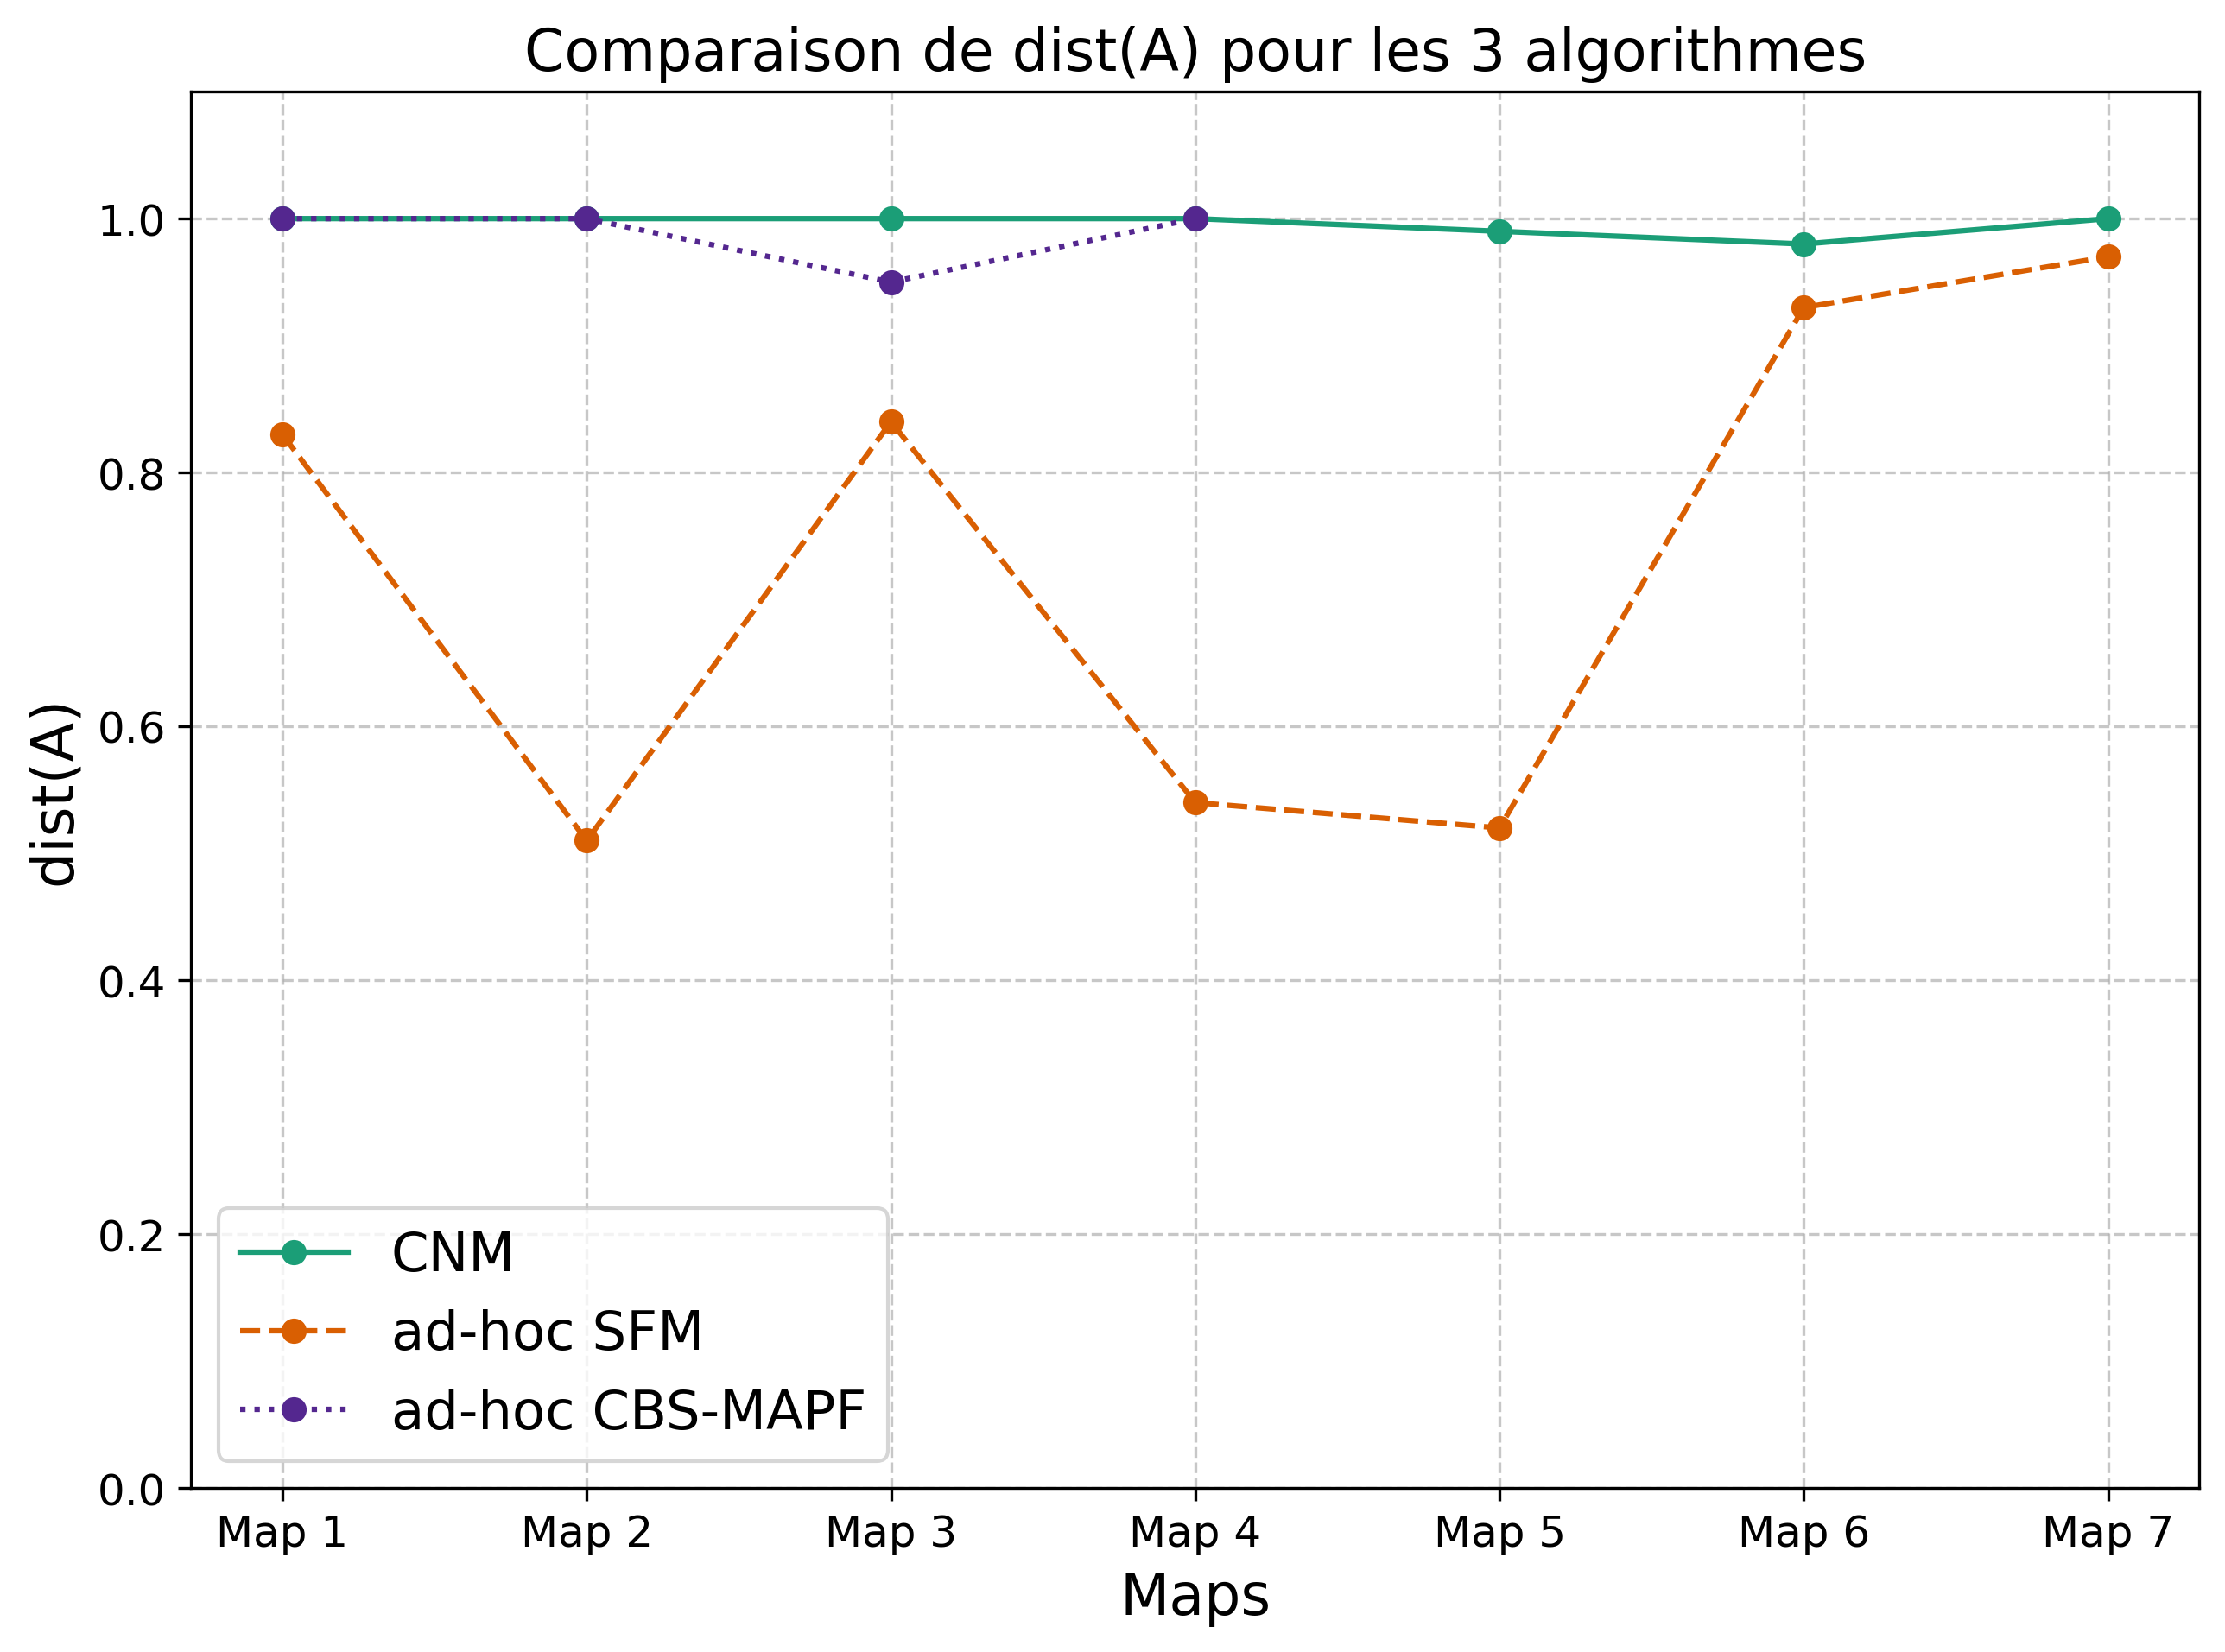

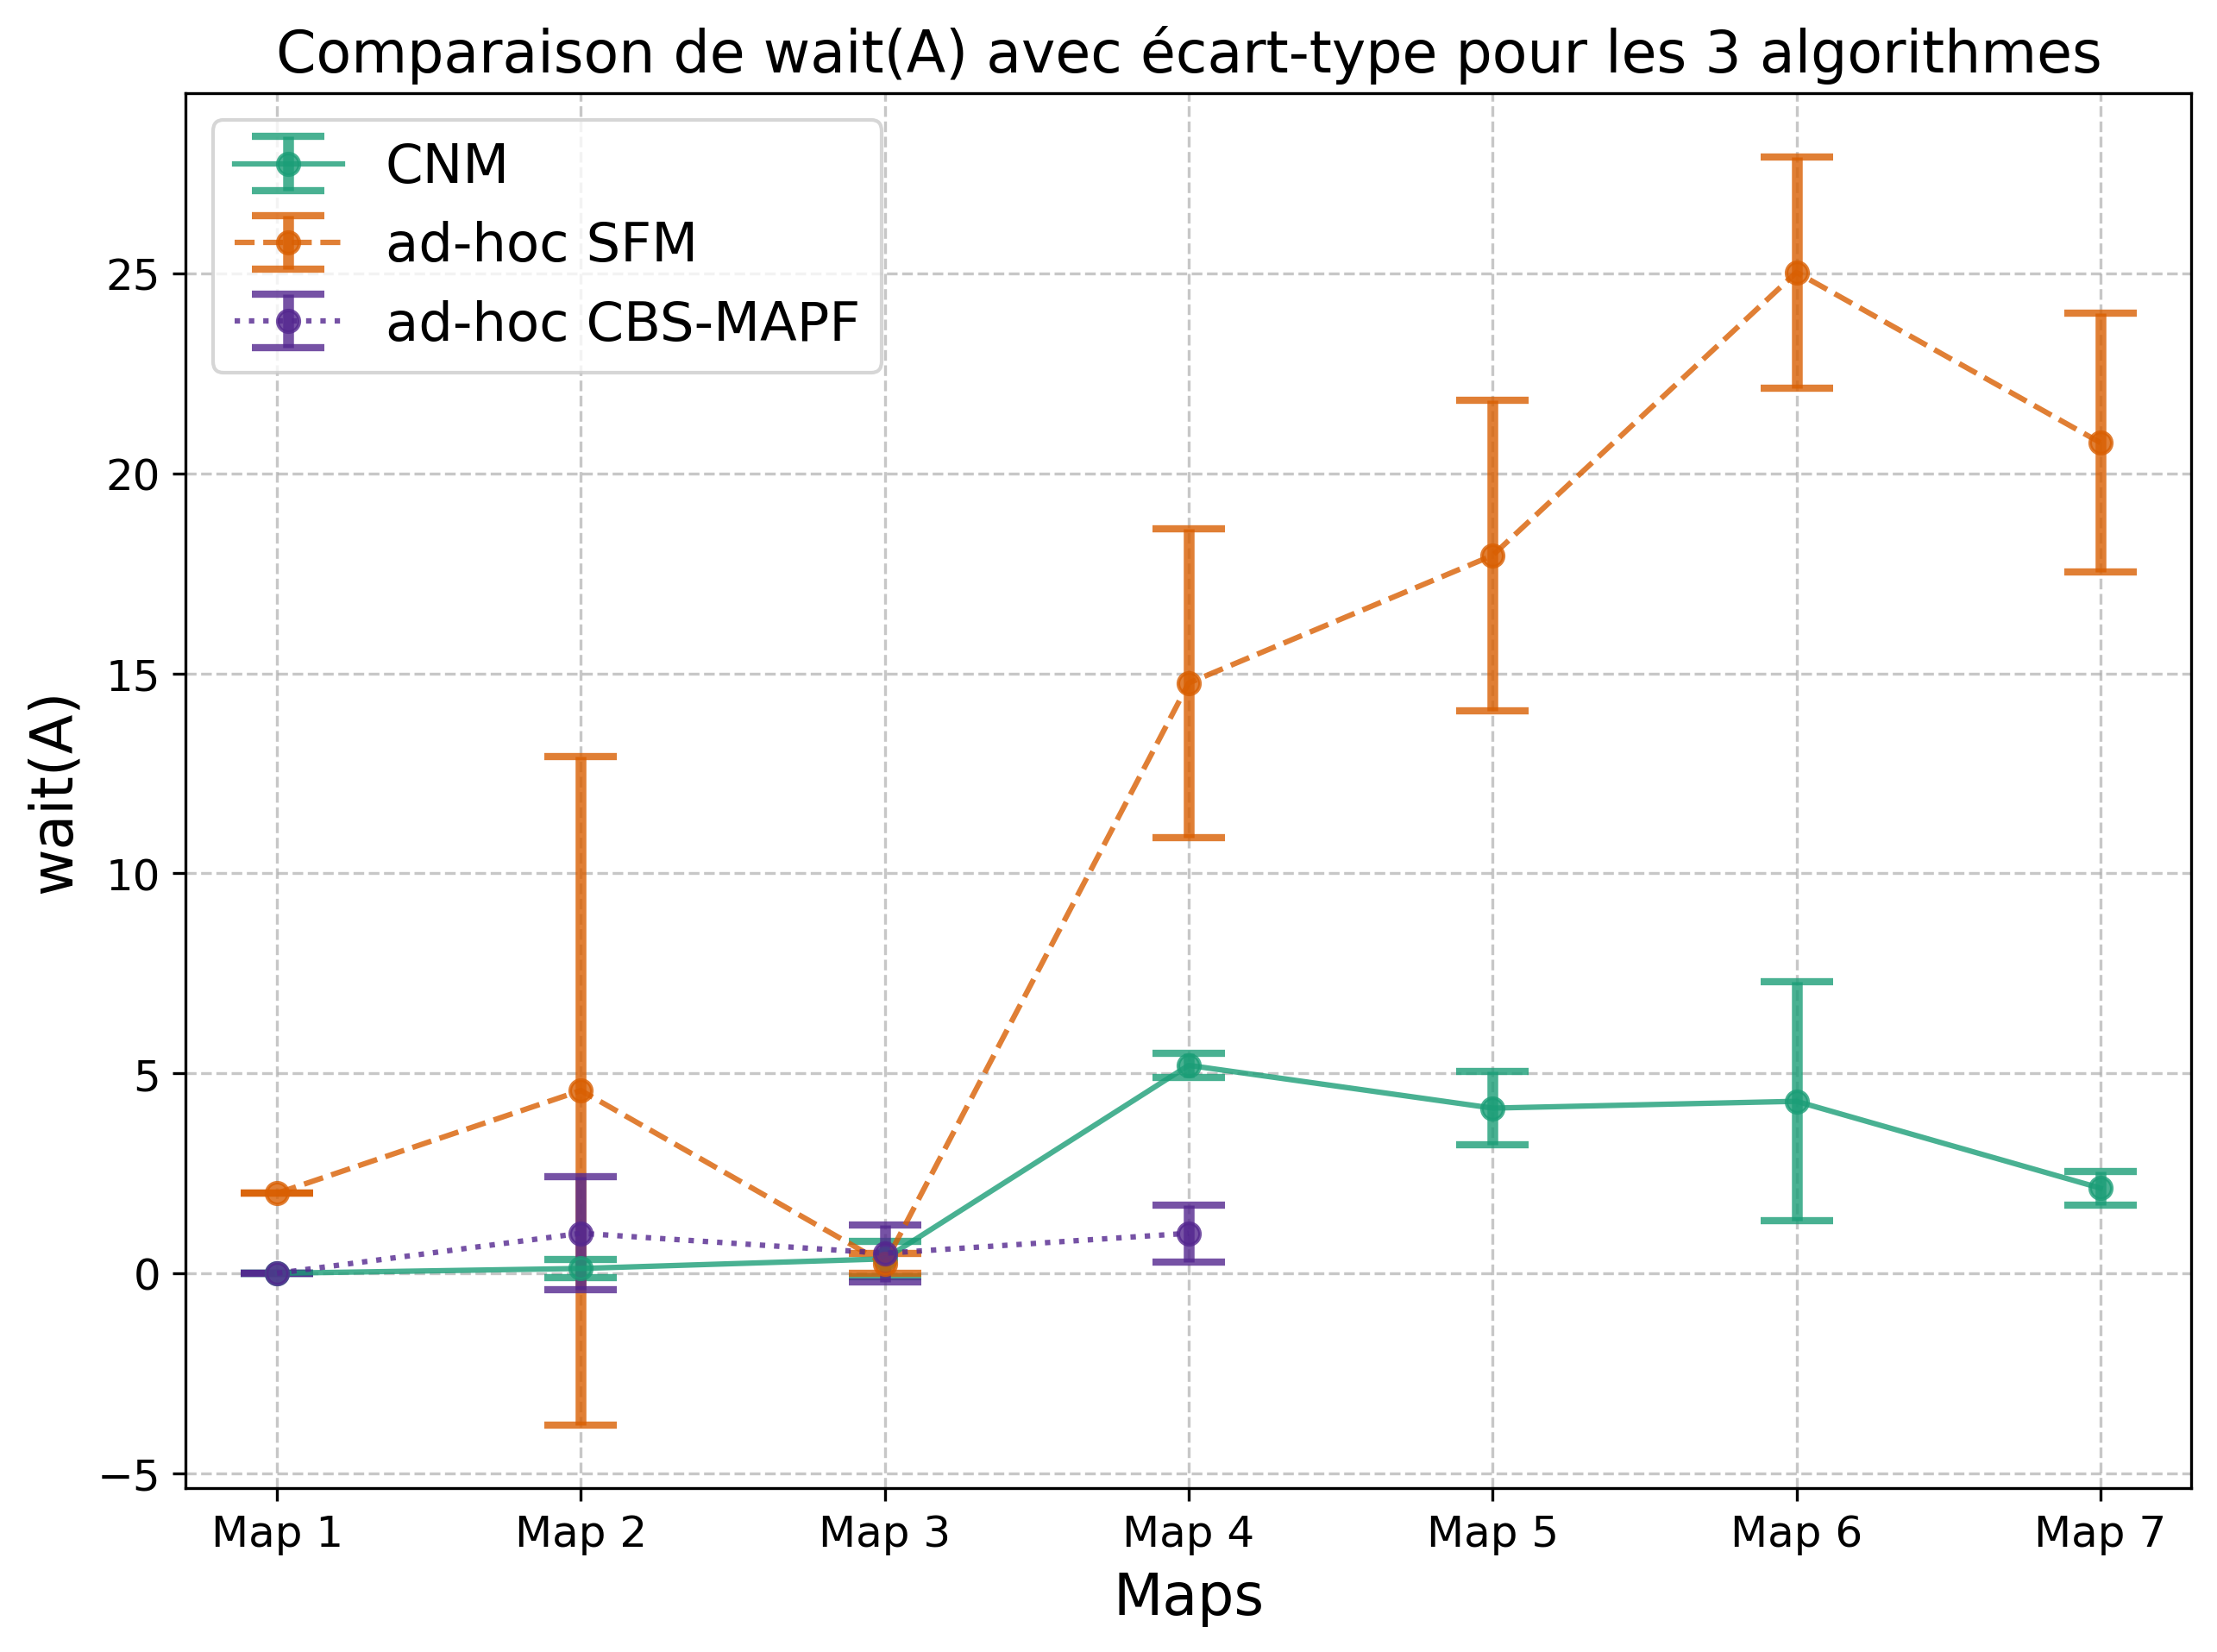

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = { # Data yielded from above evaluation.
    "CNM": [[1.0, 0.0, 0.0], [1.0, 0.12, 0.22], [1.0, 0.36, 0.44], [1.0, 5.2, 0.31], [0.99, 4.13, 0.92], [0.98, 4.3, 2.98], [1.0, 2.13, 0.42]],
    "ad-hoc SFM": [[0.83, 2.0, 0.0], [0.51, 4.57, 8.36], [0.84, 0.24, 0.25], [0.54, 14.76, 3.86], [0.52, 17.95, 3.88], [0.93, 25.03, 2.89], [0.97, 20.77, 3.24]],
    "ad-hoc CBS-MAPF": [[1.0, 0.0, 0.0], [1.0, 1.0, 1.41], [0.95, 0.5, 0.71], [1.0, 1.0, 0.71], [-1, -1, -1], [-1, -1, -1], [-1, -1, -1]]
}

maps = [f"Map {i}" for i in range(1, 8)]

# Première figure : dist pour les 3 algorithmes
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 300,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})
colors = ['#1b9e77', '#d95f02', '#54278f']
linestyles = ['-', '--', ':']

plt.figure(figsize=(10, 7))
for i, (algo, values) in enumerate(data.items()):
    metrique1 = [v[0] for v in values]
    index = metrique1.index(-1) if -1 in metrique1 else len(maps)
    plt.plot(maps[:index], metrique1[:index], label=algo, marker='o', linestyle=linestyles[i], color=colors[i])

plt.xlabel('Maps', fontsize=16)
plt.ylabel('dist(A)', fontsize=16)
plt.ylim(0, 1.1)
plt.title('Comparison of dist(A) for the 3 algorithms')
plt.legend(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Deuxième figure : wait et equi avec barres d'erreur
plt.figure(figsize=(10, 7))
for i, (algo, values) in enumerate(data.items()):
    metrique2 = [v[1] for v in values]
    std_dev = [v[2] for v in values]
    index = metrique2.index(-1) if -1 in metrique2 else len(maps)
    plt.errorbar(maps[:index], metrique2[:index], yerr=std_dev[:index], label=algo, marker='o', linestyle=linestyles[i], color=colors[i], capsize=10, capthick=2, elinewidth=3, alpha=0.8)

plt.xlabel('Maps', fontsize=16)
plt.ylabel('wait(A)', fontsize=16)
plt.title("Comparison of wait(A) with equi(A) for the 3 algorithms")
plt.legend(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
